## State-Space System Identification Example
This notebook demonstrates state-space system identification using various methods.

In [1]:
# Importing required libraries
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sippy_unipi.datasets import gen_gbn_seq, white_noise
from sippy_unipi.model_selection import aic_scorer
from sippy_unipi.plot import plot_response
from sippy_unipi.preprocessing import StandardScaler
from sippy_unipi.ss import (
    CVA,
    MOESP,
    N4SID,
    ParsimK,
    ParsimP,
    ParsimS,
    SSModel,
)

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 0
np.random.seed(seed)

### Define System Parameters

In [2]:
# Sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.0], [0.0, 0.45]])
B = np.array([[0.3], [2.5]])
C = np.array([[0.7, 1.0]])
D = np.array([[0.0]])

sys_true = SSModel._from_state(A, B, C, D)
tfin = 500
npts = int(tfin // ts) + 1
time = np.linspace(0, tfin, npts)

### Generate Input Sequence and System Output

In [3]:
# Input sequence
switch_prob = 0.05
U = gen_gbn_seq(npts, switch_prob).reshape(-1, 1)

# Output
Y = sys_true.predict(U) + white_noise(0.15, (npts, 1))

### Plot Input and Output

In [4]:
methods = [
    MLPRegressor(),
    ParsimK(),
    ParsimP(),
    ParsimS(),
    CVA(),
    MOESP(),
    N4SID(),
]

Ys_pred: list[np.ndarray | tuple] = [Y]
for method in methods:
    method: SSModel
    sys = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("model", method),
        ]
    )
    sys = sys.fit(U, Y)
    Ys_pred.append(sys.predict(U))

/Users/mw/pyprojects/SIPPY/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


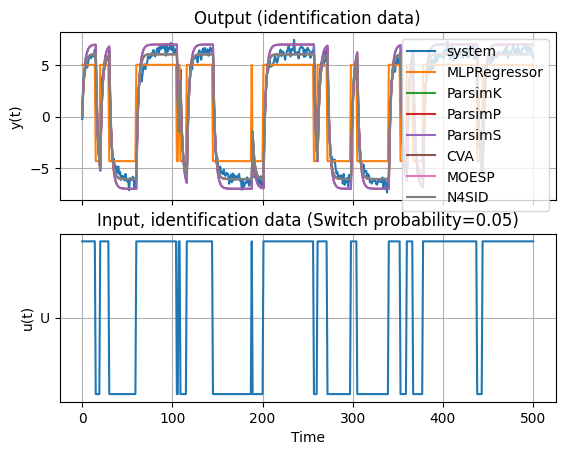

In [5]:
fig = plot_response(
    time,
    Ys_pred,
    U,
    legends=[
        ["system"] + [method.__class__.__name__ for method in methods],
        ["U"],
    ],
    titles=[
        "Output (identification data)",
        f"Input, identification data (Switch probability={switch_prob})",
    ],
)

In [6]:
methods = [
    ParsimK(),
    ParsimP(),
    ParsimS(),
    CVA(),
    MOESP(),
    N4SID(),
]

Ys_pred: list[np.ndarray | tuple] = [Y]
for method in methods:
    method: SSModel
    sys = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("model", method),
        ]
    )
    sys_search = GridSearchCV(
        sys,
        param_grid={
            "model__order": (5,),
            "model__f": (15, 20),
            "model__threshold": (0.01, 0.02, 0.05, 0.1),
        },
        cv=TimeSeriesSplit(n_splits=2),  # Time series cross-validation
        scoring=aic_scorer,
        refit=True,
        verbose=1,
    )
    sys_search = sys_search.fit(U, Y)
    Ys_pred.append(sys_search.predict(U))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits


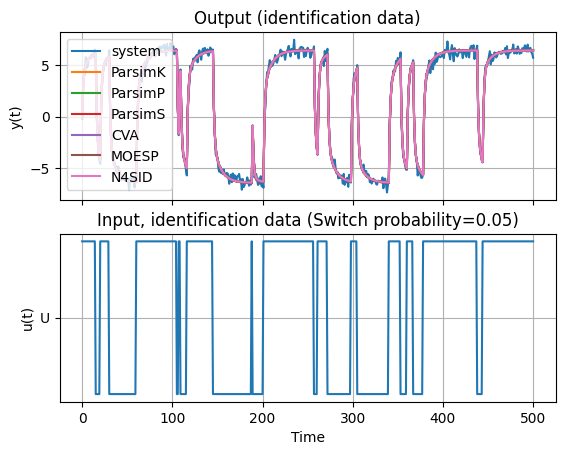

In [7]:
fig = plot_response(
    time,
    Ys_pred,
    U,
    legends=[
        ["system"] + [method.__class__.__name__ for method in methods],
        ["U"],
    ],
    titles=[
        "Output (identification data)",
        f"Input, identification data (Switch probability={switch_prob})",
    ],
)